### --------- Implementing Alexnet Architecture -------- 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time, pickle
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
import keras.backend as K

def get_categorical_accuracy_keras(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

In [3]:
nb_classes = 10
class_name = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
print("Training Dataset", x_train.shape)
print("Training Label Data", y_train.shape)
print("Test Dataset", x_test.shape)
print("Training Label Data", y_test.shape)

Training Dataset (50000, 32, 32, 3)
Training Label Data (50000, 1)
Test Dataset (10000, 32, 32, 3)
Training Label Data (10000, 1)


In [6]:
## Checking the datatype of the train and test samples
print("X_train datatype", x_train.dtype)
print("Y_train_datatype", y_train.dtype)

X_train datatype uint8
Y_train_datatype uint8


In [7]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
print("X_train shape:", x_train.shape[0])
print("X_test shape:", x_test.shape[0])

X_train shape: 50000
X_test shape: 10000


In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255
print("X_train Datatype:", x_train.dtype)
print("X_test Datatype", x_test.dtype)

X_train Datatype: float32
X_test Datatype float32


In [9]:
# Converting the labels to one-hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print("Y_train shape:", Y_train.shape)
print(Y_train)
print("Y_test shape:", Y_test.shape)
print(Y_test)

Y_train shape: (50000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Y_test shape: (10000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [10]:
## Viewing the image from the train dataset based on index id
def draw_img(i):
    im = x_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" %(c, class_name[c]))
    plt.axis("on")

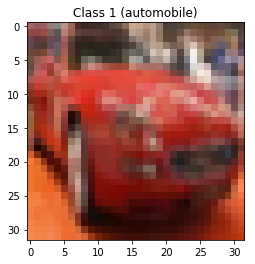

In [11]:
draw_img(5)

In [12]:
## Let's check the first 20 images in 4x5 grid:
def draw_sample(x, y, n, rows = 4, cols = 4, imfile = None, fontsize = 12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = x[n+i].reshape(32, 32, 3)
        plt.imshow(im, cmap = 'gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize = fontsize)
        plt.axis("off")
        plt.subplots_adjust(wspace = 0.6, hspace = 0.01)
    if imfile:
        plt.savefig(imfile)

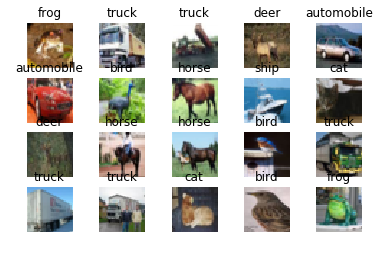

In [13]:
draw_sample(x_train, y_train, 0, 4, 5)

### -------  Building  the AlexNet Architecture ------------ 

In [14]:
img_height, img_width, channel = x_train.shape[1], x_train.shape[2], x_train.shape[3]
print("Image Height", img_height)
print("Image Width", img_width)
print("Channel", channel)

Image Height 32
Image Width 32
Channel 3


In [15]:
def alexnet_architecture():
    model = Sequential()
    
    # 1st Convolution Layer
    model.add(Conv2D(96,(11,11), strides = (4,4), activation = "relu", padding = "same", input_shape = (img_height,img_width, channel,)))
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same"))
    # Local Response normalisation for Original Alexnet
    model.add(BatchNormalization())
        
    # 2nd Convolution Layer
    model.add(Conv2D(256, (5,5),strides = (1,1) ,activation = "relu", padding = "same"))
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same"))
    model.add(BatchNormalization())
        
    # 3rd Convolution layer
    model.add(Conv2D(384, (3,3), strides = (1,1), activation = "relu", padding = "same"))
     
    # 4th Convolution Layer
    model.add(Conv2D(384, (3,3), strides = (1,1), activation = "relu", padding = "same"))
    
    # 5th Convolution Layer
    model.add(Conv2D(256, (3,3), strides = (2,2), activation = "relu", padding = "same"))
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same"))
    model.add(BatchNormalization())
              
    model.add(Flatten())
    
    # 1st Dense Layer
    model.add(Dense(4096, activation = "relu"))
    model.add(Dropout(0.4))
    
    # 2nd Dense Layer
    model.add(Dense(4096, activation = "relu"))
    model.add(Dropout(0.4))
    
    # 3rd Dense Layer
    model.add(Dense(10, activation = "softmax"))
    
    # Printing the Model Summary
    model.summary()
    return(model)

In [16]:
alexnet_model = alexnet_architecture()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 2, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 384)         885120    
__________

In [18]:
## Calling the Model
#alexnet_model = alexnet_architecture()

In [19]:
## Save the model after every epochs
checkpoint = ModelCheckpoint('best_model_simple.h5', # Model Filename
                             monitor = 'val_loss', # Quantity to monitor
                             verbose = 0, # Verbosity 0 or 1
                             save_best_only = True, # The latest best model will not be overwritten
                             mode = 'auto') # The decision to overwrite model is made automatically depending on the quantity to monitor

In [20]:
## Compile the Model
alexnet_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = [get_categorical_accuracy_keras])

In [21]:
#### Fit the model on the traing Data
model_details = alexnet_model.fit(x_train , Y_train,
                         batch_size = 128, # Number of Samples per gradient update
                          epochs = 100, # Number of iterations
                          validation_data = (x_test , Y_test),
                          callbacks = [checkpoint],
                          verbose = 1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 931s 19ms/step - loss: 1.6393 - get_categorical_accuracy_keras: 0.4025 - val_loss: 2.5446 - val_get_categorical_accuracy_keras: 0.3038
Epoch 2/100
50000/50000 [==============================] - 938s 19ms/step - loss: 1.3217 - get_categorical_accuracy_keras: 0.5226 - val_loss: 1.5395 - val_get_categorical_accuracy_keras: 0.4576
Epoch 3/100
50000/50000 [==============================] - 909s 18ms/step - loss: 1.1712 - get_categorical_accuracy_keras: 0.5846 - val_loss: 1.6466 - val_get_categorical_accuracy_keras: 0.4788
Epoch 4/100
50000/50000 [==============================] - 908s 18ms/step - loss: 1.0450 - get_categorical_accuracy_keras: 0.6358 - val_loss: 1.5058 - val_get_categorical_accuracy_keras: 0.5067
Epoch 5/100
50000/50000 [==============================] - 911s 18ms/step - loss: 0.9029 - get_categorical_accuracy_keras: 0.6864 - val_loss: 1.1527 - val_get_categorical_acc

Epoch 43/100
50000/50000 [==============================] - 908s 18ms/step - loss: 0.0424 - get_categorical_accuracy_keras: 0.9866 - val_loss: 2.4121 - val_get_categorical_accuracy_keras: 0.6424
Epoch 44/100
50000/50000 [==============================] - 897s 18ms/step - loss: 0.0369 - get_categorical_accuracy_keras: 0.9879 - val_loss: 2.2730 - val_get_categorical_accuracy_keras: 0.6468
Epoch 45/100
50000/50000 [==============================] - 908s 18ms/step - loss: 0.0394 - get_categorical_accuracy_keras: 0.9875 - val_loss: 2.2497 - val_get_categorical_accuracy_keras: 0.6376
Epoch 46/100
50000/50000 [==============================] - 910s 18ms/step - loss: 0.0414 - get_categorical_accuracy_keras: 0.9866 - val_loss: 2.8654 - val_get_categorical_accuracy_keras: 0.5954
Epoch 47/100
50000/50000 [==============================] - 908s 18ms/step - loss: 0.0441 - get_categorical_accuracy_keras: 0.9863 - val_loss: 2.2030 - val_get_categorical_accuracy_keras: 0.6586
Epoch 48/100
50000/50000 

Epoch 85/100
50000/50000 [==============================] - 930s 19ms/step - loss: 0.0185 - get_categorical_accuracy_keras: 0.9948 - val_loss: 2.3950 - val_get_categorical_accuracy_keras: 0.6669
Epoch 86/100
50000/50000 [==============================] - 943s 19ms/step - loss: 0.0203 - get_categorical_accuracy_keras: 0.9943 - val_loss: 2.4844 - val_get_categorical_accuracy_keras: 0.6586
Epoch 87/100
50000/50000 [==============================] - 975s 19ms/step - loss: 0.0198 - get_categorical_accuracy_keras: 0.9942 - val_loss: 2.5479 - val_get_categorical_accuracy_keras: 0.6660
Epoch 88/100
50000/50000 [==============================] - 1003s 20ms/step - loss: 0.0257 - get_categorical_accuracy_keras: 0.9932 - val_loss: 2.4108 - val_get_categorical_accuracy_keras: 0.6574
Epoch 89/100
50000/50000 [==============================] - 995s 20ms/step - loss: 0.0272 - get_categorical_accuracy_keras: 0.9925 - val_loss: 2.2697 - val_get_categorical_accuracy_keras: 0.6717
Epoch 90/100
50000/50000

In [22]:
# Predict the class for test set images
class_pred = alexnet_model.predict(x_test,batch_size = 32)
print(class_pred[0])

[6.2986683e-09 1.3546886e-10 2.1212783e-08 9.9999928e-01 2.0340922e-08
 5.6758478e-07 2.8711133e-08 6.9889559e-08 1.4341657e-08 8.7731811e-10]


In [23]:
# Get the index of the largest element in each vector
labels_pred = np.argmax(class_pred ,axis = 1)
print(labels_pred)

[3 1 8 ... 5 4 7]


In [25]:
# Calculating the Model Accuracy of train dataset
loss, accuracy = alexnet_model.evaluate(x_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.991260  ;  loss = 0.027992


In [26]:
# Calculating the Model Accuracy of test dataset
loss, accuracy = alexnet_model.evaluate(x_test, Y_test, verbose=0)
print("Validation: accuracy = %f  ;  loss1 = %f" % (accuracy, loss))

Validation: accuracy1 = 0.665700  ;  loss1 = 2.224479


In [27]:
y_pred = alexnet_model.predict_classes(x_test)
y_pred

array([3, 1, 8, ..., 5, 4, 7])

In [28]:
# Calculating the correctly classified and misclassified images
true_preds = [(x,y) for (x,y,p) in zip(x_test , y_test , y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(x_test , y_test , y_pred) if y != p]

print("Number of True Predictions: ",len(true_preds))
print("Number of False Predictions: ",len(false_preds))

Number of True Predictions:  6657
Number of False Predictions:  3343


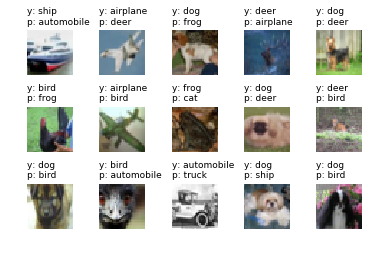

In [29]:
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(3,5, i+1)
    plt.imshow(x, cmap = 'gnuplot2')
    plt.title("y: %s\np: %s" %(class_name[y] , class_name[p]) , fontsize = 9,loc = "left")
    plt.axis('off')
    plt.subplots_adjust(wspace = 0.6, hspace = 0.2)